### Подключаем библиотеки

In [1]:
# torch

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T

from torchvision import io
from torchvision import datasets
import torchutils as tu

# base

import numpy as np
import matplotlib.pyplot as plt

# style 

import mplcyberpunk
plt.style.use("cyberpunk")


#### Переключаем вычисления на видеокарту, если это возможно


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

> Посмотрим структуру датасета

In [3]:
!ls ../images/weather/

dew	 frost	hail	   rain     rime       snow
fogsmog  glaze	lightning  rainbow  sandstorm


In [4]:
PATH = '../images/weather'

> Видим, что разделение на обучающую и валидационную выборок нет, сделаем её

In [5]:
# Будем преобразовывать изображение согласно модели, которую решили взять

transform = T.Compose([
    T.Resize((224, 224)), # ResNet18 поддерживает такой формат, так что ставим его
    T.ToTensor()
])

In [7]:
# Создаём наш датасет из данных, которые у нас есть

dataset = datasets.ImageFolder(PATH, transform=transform)

# В явном виде указываем доли для обучения
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size

train_ds, valid_ds = random_split(dataset, lengths=(.8, .2))

> Создаём __DataLoader__

In [9]:
BATCH_SIZE = 256

train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=BATCH_SIZE)

In [10]:
print(train_ds)
print(train_loader)

> Посмотрим картиночки

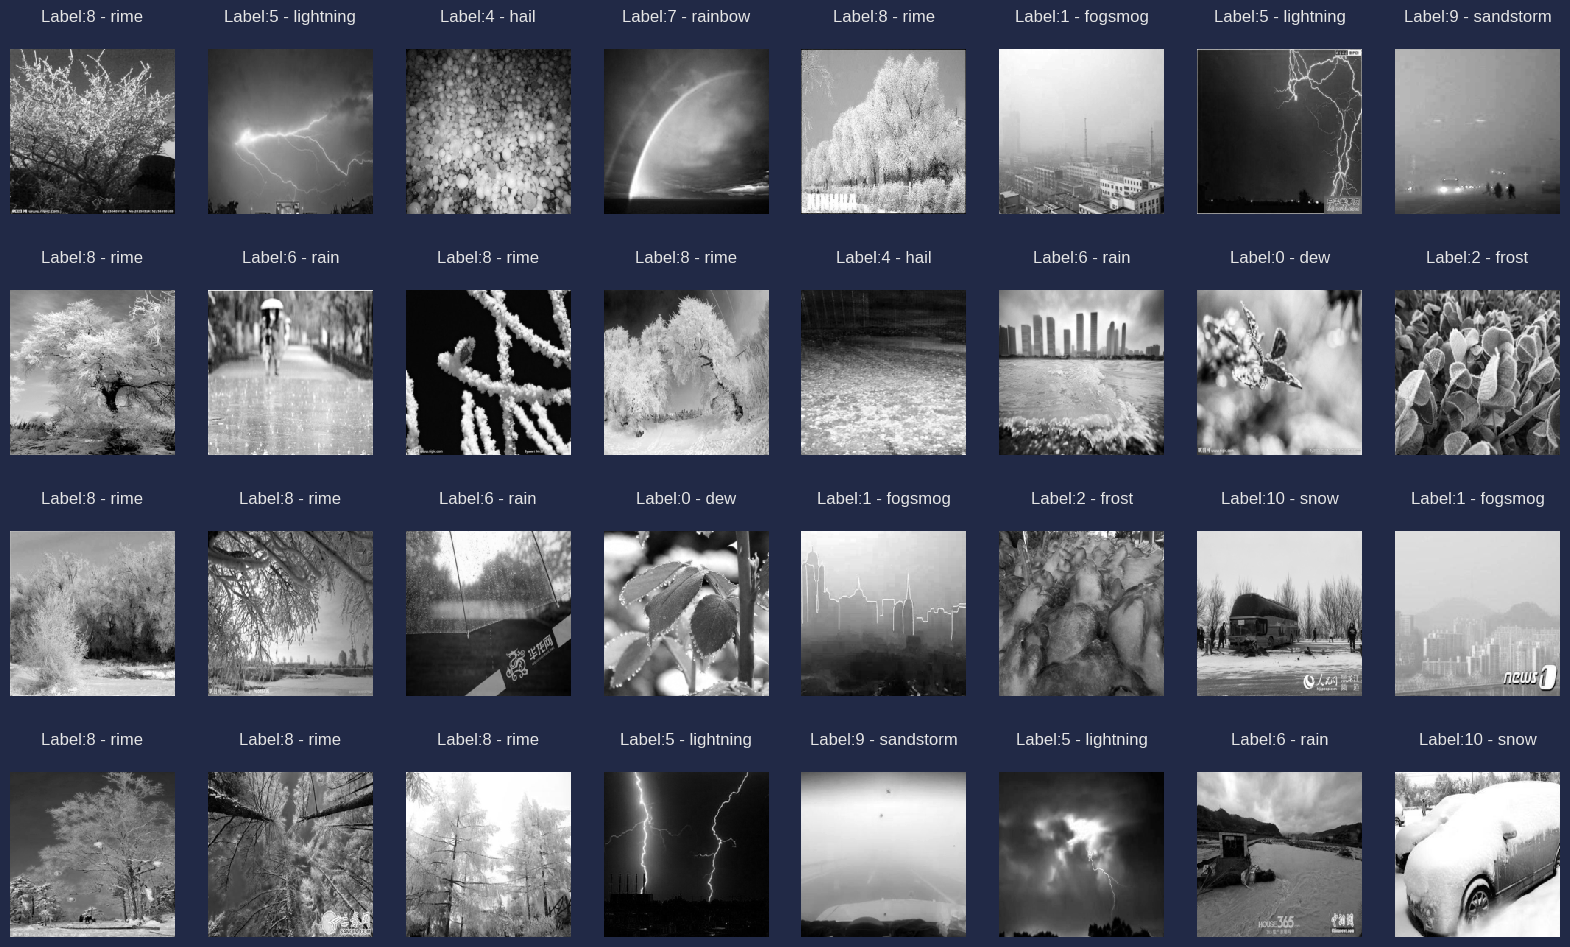

In [21]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels

# распечатаем произвольную картинку
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
batch, labels = get_batch_from_loader(train_loader)
for i, plot in enumerate(ax[:len(batch)]):
    plot.set_title(f'Label:{labels[i]} - {train_loader.dataset.dataset.classes[labels[i].item()]}')
    plot.matshow(batch[i][0, :, :], cmap='gray')
    plot.axis('off')

Посмотрим на размерности ещё раз

In [14]:
for batch_1, batch_2 in train_loader:
    print(f'Размер данных {batch_1.shape}')
    break

Размер данных torch.Size([256, 3, 224, 224])


#### Подгружаем модельку

In [22]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [23]:
# Посмотрим на структуру модели
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Заменим выходной слой

model.fc = nn.Linear(512, 11)

In [25]:
# Заморозим слои модели, чтобы применит все изменения, которые нам нужны

for param in model.parameters():
    param.requires_grad = False

In [26]:
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [27]:
# Посмотрим, что у нас будет тренироваться, а что останется нетронутым

for i, params in model.named_parameters():
    print(f"{i}: {'Будем тренировать' if params.requires_grad else 'ЗАМОРОЖЕНО'}")

conv1.weight: ЗАМОРОЖЕНО
bn1.weight: ЗАМОРОЖЕНО
bn1.bias: ЗАМОРОЖЕНО
layer1.0.conv1.weight: ЗАМОРОЖЕНО
layer1.0.bn1.weight: ЗАМОРОЖЕНО
layer1.0.bn1.bias: ЗАМОРОЖЕНО
layer1.0.conv2.weight: ЗАМОРОЖЕНО
layer1.0.bn2.weight: ЗАМОРОЖЕНО
layer1.0.bn2.bias: ЗАМОРОЖЕНО
layer1.1.conv1.weight: ЗАМОРОЖЕНО
layer1.1.bn1.weight: ЗАМОРОЖЕНО
layer1.1.bn1.bias: ЗАМОРОЖЕНО
layer1.1.conv2.weight: ЗАМОРОЖЕНО
layer1.1.bn2.weight: ЗАМОРОЖЕНО
layer1.1.bn2.bias: ЗАМОРОЖЕНО
layer2.0.conv1.weight: ЗАМОРОЖЕНО
layer2.0.bn1.weight: ЗАМОРОЖЕНО
layer2.0.bn1.bias: ЗАМОРОЖЕНО
layer2.0.conv2.weight: ЗАМОРОЖЕНО
layer2.0.bn2.weight: ЗАМОРОЖЕНО
layer2.0.bn2.bias: ЗАМОРОЖЕНО
layer2.0.downsample.0.weight: ЗАМОРОЖЕНО
layer2.0.downsample.1.weight: ЗАМОРОЖЕНО
layer2.0.downsample.1.bias: ЗАМОРОЖЕНО
layer2.1.conv1.weight: ЗАМОРОЖЕНО
layer2.1.bn1.weight: ЗАМОРОЖЕНО
layer2.1.bn1.bias: ЗАМОРОЖЕНО
layer2.1.conv2.weight: ЗАМОРОЖЕНО
layer2.1.bn2.weight: ЗАМОРОЖЕНО
layer2.1.bn2.bias: ЗАМОРОЖЕНО
layer3.0.conv1.weight: ЗАМОРОЖЕНО
layer3.0

In [ ]:
# Выделим одну картинку
test_batch = next(iter(valid_loader))
test_samples, _ = test_batch
# Получим сводную информацию о модели
tu.get_model_summary(model.to(DEVICE), test_samples[1].unsqueeze(0).to(DEVICE))

Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                              [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                -   [1, 64, 112, 112]           0             0
3_maxpool                                             -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
5_layer1.0.BatchNorm2d_bn1                         [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                  -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                         [64]     [1, 64, 56, 56]       

#### Создадим новый optimizer для последнего слоя, напишем функцию fit() для модели

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
def fit(
        model: torch.nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        history = None,
        criterion=criterion,
        ) -> tuple[list, ...]:

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_accs'])

    for epoch in range(start_epoch+1, start_epoch+n_epochs+1):
        
        print(f'{"-"*11} Epoch {epoch}/{n_epochs} {"-"*11}')

        model.train()
        batch_accs = []
        batch_losses = [] 

        for images, labels in train_loader:
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        model.eval()

        batch_losses = []
        batch_accs = []

        for images, labels in valid_loader:

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():
                y_pred = model(images.to(DEVICE))
            
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history

#### Начнём обучение, сразу посмотрим на метрики, затем построим графики


In [34]:
res_weather = fit(model=model, n_epochs=5, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion)

----------- Epoch 1/5 -----------
train: accuracy 0.2662, loss 2.1486
valid: accuracy 0.4746, loss 1.8201
-----------------------------------

----------- Epoch 2/5 -----------
train: accuracy 0.5896, loss 1.5421
valid: accuracy 0.6390, loss 1.3457
-----------------------------------

----------- Epoch 3/5 -----------
train: accuracy 0.7205, loss 1.1739
valid: accuracy 0.7426, loss 1.0619
-----------------------------------

----------- Epoch 4/5 -----------
train: accuracy 0.7747, loss 0.9579
valid: accuracy 0.7626, loss 0.9329
-----------------------------------

----------- Epoch 5/5 -----------
train: accuracy 0.8062, loss 0.8268
valid: accuracy 0.7931, loss 0.8131
-----------------------------------



Достаточно неплохая точность, попробуем ещё 5 эпох добавить


In [35]:
res_weather_10e = fit(model=model, n_epochs=5, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather)

----------- Epoch 6/5 -----------
train: accuracy 0.8204, loss 0.7428
valid: accuracy 0.8078, loss 0.7501
-----------------------------------

----------- Epoch 7/5 -----------
train: accuracy 0.8334, loss 0.6704
valid: accuracy 0.8178, loss 0.6970
-----------------------------------

----------- Epoch 8/5 -----------
train: accuracy 0.8379, loss 0.6269
valid: accuracy 0.8289, loss 0.6590
-----------------------------------

----------- Epoch 9/5 -----------
train: accuracy 0.8495, loss 0.5839
valid: accuracy 0.8252, loss 0.6315
-----------------------------------

----------- Epoch 10/5 -----------
train: accuracy 0.8535, loss 0.5576
valid: accuracy 0.8284, loss 0.5986
-----------------------------------



In [36]:
res_weather_20e = fit(model=model, n_epochs=10, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather_10e)

----------- Epoch 11/10 -----------
train: accuracy 0.8584, loss 0.5294
valid: accuracy 0.8386, loss 0.5841
-----------------------------------

----------- Epoch 12/10 -----------
train: accuracy 0.8596, loss 0.5085
valid: accuracy 0.8414, loss 0.5589
-----------------------------------

----------- Epoch 13/10 -----------
train: accuracy 0.8726, loss 0.4883
valid: accuracy 0.8400, loss 0.5506
-----------------------------------

----------- Epoch 14/10 -----------
train: accuracy 0.8711, loss 0.4717
valid: accuracy 0.8556, loss 0.5297
-----------------------------------

----------- Epoch 15/10 -----------
train: accuracy 0.8718, loss 0.4589
valid: accuracy 0.8507, loss 0.5167
-----------------------------------

----------- Epoch 16/10 -----------
train: accuracy 0.8734, loss 0.4460
valid: accuracy 0.8473, loss 0.5265
-----------------------------------

----------- Epoch 17/10 -----------
train: accuracy 0.8765, loss 0.4368
valid: accuracy 0.8499, loss 0.5095
----------------------

In [37]:
res_weather_30e = fit(model=model, n_epochs=10, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion, history=res_weather_20e)

----------- Epoch 21/10 -----------
train: accuracy 0.8863, loss 0.3939
valid: accuracy 0.8554, loss 0.4792
-----------------------------------

----------- Epoch 22/10 -----------
train: accuracy 0.8865, loss 0.3911
valid: accuracy 0.8577, loss 0.4742
-----------------------------------

----------- Epoch 23/10 -----------
train: accuracy 0.8899, loss 0.3801
valid: accuracy 0.8609, loss 0.4641
-----------------------------------

----------- Epoch 24/10 -----------
train: accuracy 0.8883, loss 0.3811
valid: accuracy 0.8652, loss 0.4607
-----------------------------------

----------- Epoch 25/10 -----------
train: accuracy 0.8925, loss 0.3654
valid: accuracy 0.8631, loss 0.4547
-----------------------------------

----------- Epoch 26/10 -----------
train: accuracy 0.8956, loss 0.3609
valid: accuracy 0.8480, loss 0.4704
-----------------------------------

----------- Epoch 27/10 -----------
train: accuracy 0.8974, loss 0.3553
valid: accuracy 0.8580, loss 0.4694
----------------------

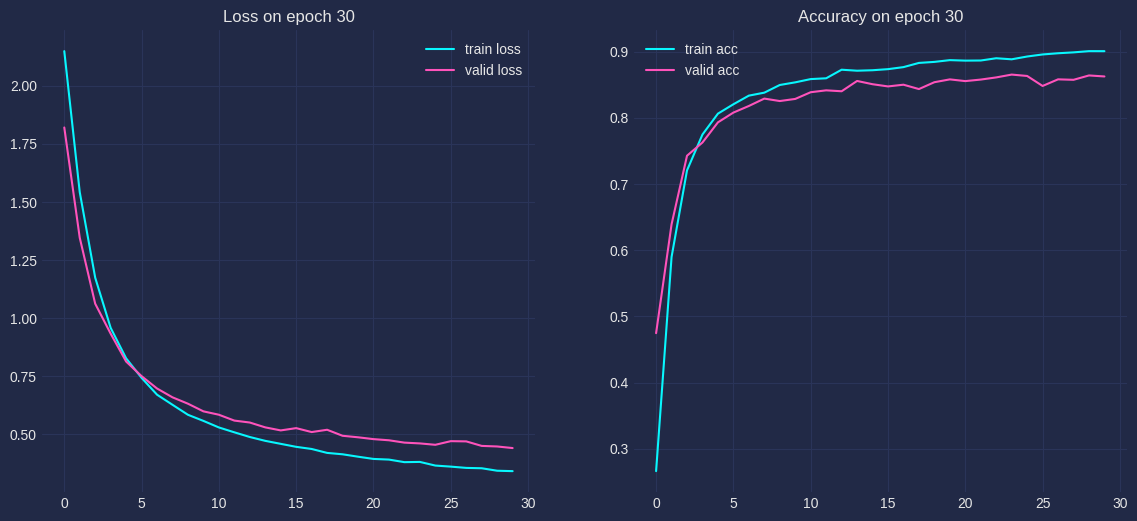

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6)) # type:ignore 

ax[0].plot(res_weather_30e['train_losses'], label='train loss')
ax[0].plot(res_weather_30e['valid_losses'], label='valid loss')
ax[0].set_title(f'Loss on epoch {len(res_weather_30e["train_losses"])}')
#ax[0].set_ylim((0.35, 0.55))
ax[0].legend()

ax[1].plot(res_weather_30e['train_accs'], label='train acc')
ax[1].plot(res_weather_30e['valid_accs'], label='valid acc')
ax[1].set_title(f'Accuracy on epoch {len(res_weather_30e["train_losses"])}')
#ax[1].set_ylim((0.75, 0.9))
ax[1].legend()

plt.show()

#### Время не выводил, в последствии буду записывать время работы в отдельную переменную, либо вывод в "консоль"

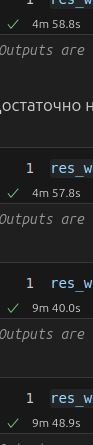

In [45]:
time_seg = [
    (5, 4*60 + 58.8),     # Первые 5 эпох, прогнанные через модель за время, которое указано выше
    (5, 4 * 60 + 57.8),   # Вторые 5 эпох
    (10, 9 * 60 + 40),    # Третья итерация обучения, + 10 эпох
    (10, 9 * 60 + 49)     # Последние 10 эпох
]

num_epochs = []
cumulative_time = 0
times = []

for epochs, time in time_seg:
    for _ in range(epochs):
        cumulative_time += time / epochs
        times.append(cumulative_time)
        num_epochs.append(len(num_epochs) + 1)

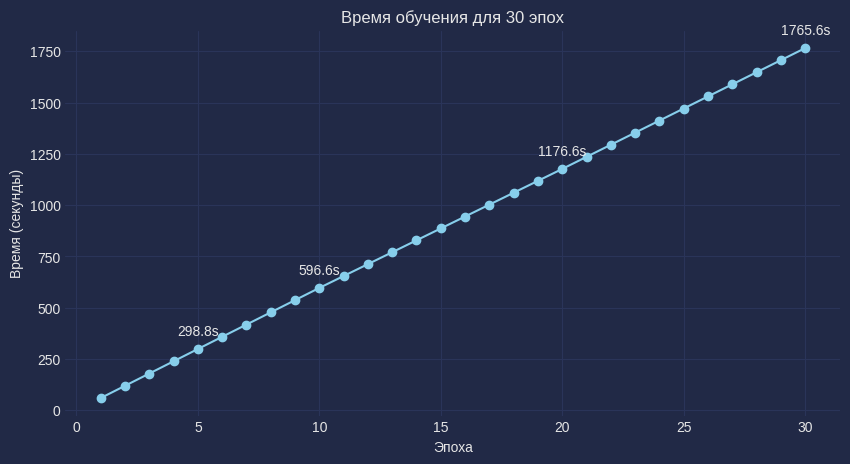

In [ ]:
# Строим график времени

plt.figure(figsize=(10, 5))
plt.plot(num_epochs, times, marker='o', color='skyblue')
plt.title(f'Время обучения для {max(num_epochs)} эпох')
plt.xlabel('Эпоха')
plt.ylabel("Время (секунды)")
plt.grid(True)

for i, txt in enumerate(times):
    if i in [4, 9, 19, 29]:  # Ключевые точки, 5, 10, 20 и 30 эпохи соответственно
        plt.annotate(f'{txt:.1f}s', (num_epochs[i], times[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

In [69]:
model_weights = '../models/resnet_weather_weights.pt'

torch.save(model.state_dict(), model_weights)